In [1]:
import os
import scanpy as sc
import anndata as ad

In [2]:
in_dir = '../../data/ssc_mouse'
out_dir = '../../results/08_mouse_ssc/01_integrate_data'

os.makedirs(out_dir, exist_ok=True)

In [3]:
samples = {'day0_sample1': 'B1-1_togather',
           'day3_sample1': 'B2-1_togather',
           'day3_sample2': 'B2-2_togather',
           'day7_sample1': 'B3-1_togather',
           'day7_sample2': 'B3-2_togather',
           'day14_sample1': 'B4-1_togather',
           'day14_sample2': 'B4-2_togather',
           'day28_sample1': 'B5-1_togather',
           'day28_sample2': 'B5-2_togather'}

In [4]:
adata_list = []

for key, value in samples.items():
    adata = sc.read_10x_mtx(f'{in_dir}/{value}/filtered_feature_bc_matrix')
    adata.obs['sample'] = key
    
    adata_list.append(adata)

In [5]:
adata = ad.concat(adata_list)
adata.obs_names_make_unique()

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/zl_envs/zl_igvf/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("mt-")

# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)

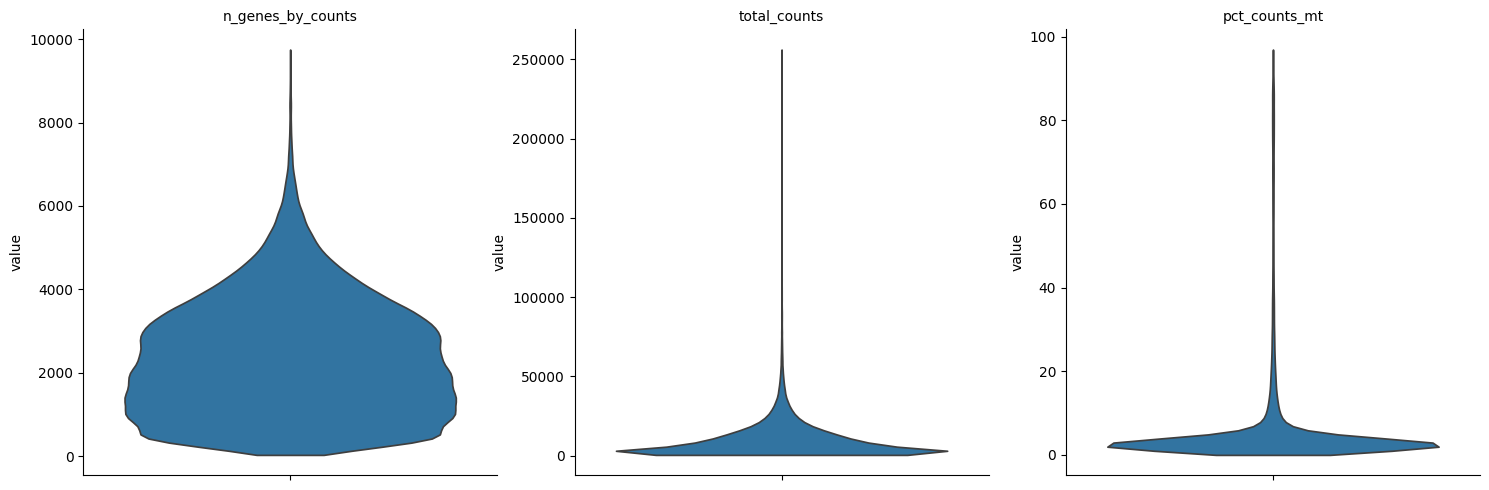

In [8]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    size=0,
    multi_panel=True,
)

In [9]:
adata

AnnData object with n_obs × n_vars = 102697 × 32285
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [10]:
sc.pp.filter_cells(adata, inplace=True, min_counts=2000)
sc.pp.filter_cells(adata, inplace=True, min_genes=200)

adata = adata[adata.obs['pct_counts_mt'] < 5, :]

In [11]:
sc.pp.filter_cells(adata, inplace=True, max_genes=6000)
sc.pp.filter_cells(adata, inplace=True, max_counts=40000)

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/zl_envs/zl_igvf/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


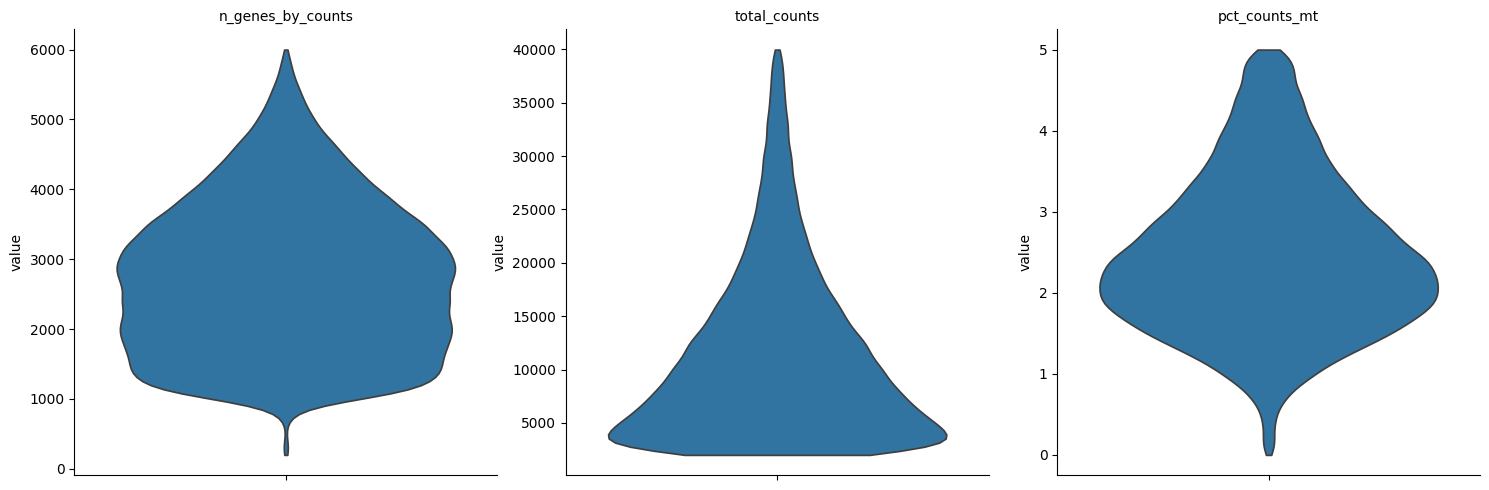

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    size=0,
    multi_panel=True,
)

<Axes: xlabel='sample'>

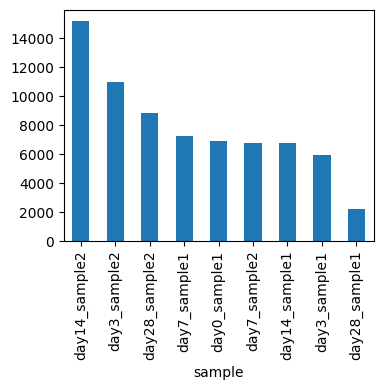

In [13]:
adata.obs["sample"].value_counts().plot(kind='bar', figsize=(4, 3))

<Axes: xlabel='time_point'>

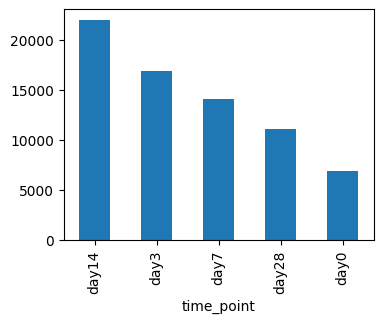

In [14]:
# add time point information
adata.obs['time_point'] = [sample.split("_")[0] for sample in adata.obs['sample'].values.tolist()]
adata.obs["time_point"].value_counts().plot(kind='bar', figsize=(4, 3))

In [15]:
adata.raw = adata

In [16]:
adata.layers['counts'] = adata.X

In [17]:
adata

AnnData object with n_obs × n_vars = 70820 × 32285
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'n_genes', 'time_point'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [18]:
adata.write_h5ad(f'{out_dir}/adata.h5ad')